In [34]:
# baseline model(s) with features based on previous reaserch

In [159]:
#global imports
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
#model metrics
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score,classification_report,roc_auc_score,f1_score,precision_recall_fscore_support
from model_statistics_func import plot_confusion_matrix,get_feature_importance

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# approach
1.types of datasets:
    1.0 keep everything
    1.1 true and untrue statements only
    1.2 true vs all other ( all others label than true consider as untrue)
    1.3 keep only written statements
   

# load dataset

In [160]:
raw_dataset=pd.read_pickle('dataset.pkl')

In [161]:
raw_dataset.head(6)

,word_count,distinct_word_count,avg_chars_per_word,TTR,Flesch_Kincaid,h_hayedia_count,syllabls_count,uncertainty_words_usage,first_names_usage,last_names_usage,...,BEINONI,PAST,FUTURE,IMPERATIVE,qoutes_count,hashtag_count,positive_semantic,negative_semantic,objective_semantic,score_code
0,18,18,4.388889,1.000000,62.758571,0.040000,34,0,4,3,...,0,3,0,0,0,0,0.980871,0.012410,0.006719,1.0
1,57,52,4.052632,0.912281,23.543135,0.072289,121,0,3,6,...,0,2,0,0,0,0,0.615095,0.309213,0.075692,0.5
2,31,26,3.838710,0.838710,21.447143,0.088889,62,0,3,1,...,0,0,1,0,0,0,0.054728,0.894451,0.050821,0.5
3,32,32,4.000000,1.000000,19.895000,0.106383,64,0,4,5,...,0,1,0,0,0,0,0.766881,0.188297,0.044822,1.0
4,19,19,4.842105,1.000000,-0.076818,0.156250,48,0,0,2,...,0,3,0,0,0,0,0.994935,0.003275,0.001790,1.0
5,25,21,4.640000,0.840000,14.165776,0.139535,61,0,0,4,...,1,3,1,0,0,0,0.756158,0.199218,0.044624,0.8


In [162]:
def convert_numeric_score_to_cat(score_code):
    score_dict={0:'TRUE',0.2:'mostly true',0.5:'half true',0.7:'misleading',0.8:'mostly untrue',1:'untrue'}
    return score_dict.get(score_code)

raw_dataset['score']=raw_dataset['score_code'].apply(lambda x: convert_numeric_score_to_cat(x))
raw_dataset.drop('score_code',axis=1,inplace=True)

In [163]:
raw_dataset.head(6)

,word_count,distinct_word_count,avg_chars_per_word,TTR,Flesch_Kincaid,h_hayedia_count,syllabls_count,uncertainty_words_usage,first_names_usage,last_names_usage,...,BEINONI,PAST,FUTURE,IMPERATIVE,qoutes_count,hashtag_count,positive_semantic,negative_semantic,objective_semantic,score
0,18,18,4.388889,1.000000,62.758571,0.040000,34,0,4,3,...,0,3,0,0,0,0,0.980871,0.012410,0.006719,untrue
1,57,52,4.052632,0.912281,23.543135,0.072289,121,0,3,6,...,0,2,0,0,0,0,0.615095,0.309213,0.075692,half true
2,31,26,3.838710,0.838710,21.447143,0.088889,62,0,3,1,...,0,0,1,0,0,0,0.054728,0.894451,0.050821,half true
3,32,32,4.000000,1.000000,19.895000,0.106383,64,0,4,5,...,0,1,0,0,0,0,0.766881,0.188297,0.044822,untrue
4,19,19,4.842105,1.000000,-0.076818,0.156250,48,0,0,2,...,0,3,0,0,0,0,0.994935,0.003275,0.001790,untrue
5,25,21,4.640000,0.840000,14.165776,0.139535,61,0,0,4,...,1,3,1,0,0,0,0.756158,0.199218,0.044624,mostly untrue


In [164]:
raw_dataset.groupby(['score'])['score'].count()

score
TRUE              75
half true         56
misleading         7
mostly true       37
mostly untrue     99
untrue           203
Name: score, dtype: int64

### datasets options

In [165]:
def return_raw_dataset(dataset):
    #do nothing
    return dataset


def trueNuntrueStmt(dataset):
    #return dataset[(dataset.score==0) | (dataset.score==1.0)]
    return dataset[(dataset.score=='TRUE') | (dataset.score=='untrue')]


def trueVSall(dataset):
    def smooth_to_untrue(label):
        if label!='TRUE':
            return 'untrue'
        else:
            return 'TRUE'
    dataset['score']=dataset['score'].apply(lambda x:smooth_to_untrue(x))
    return dataset


def written_only(dataset):
    media_type=pd.read_csv('media_type.csv')
    dataset=pd.concat([dataset,media_type],axis=1)
    dataset=dataset[dataset.media=='written']
    dataset.drop('media',inplace=True,axis=1)
    return dataset

In [166]:
raw_dataset

,word_count,distinct_word_count,avg_chars_per_word,TTR,Flesch_Kincaid,h_hayedia_count,syllabls_count,uncertainty_words_usage,first_names_usage,last_names_usage,...,BEINONI,PAST,FUTURE,IMPERATIVE,qoutes_count,hashtag_count,positive_semantic,negative_semantic,objective_semantic,score
0,18,18,4.388889,1.000000,62.758571,0.040000,34,0,4,3,...,0,3,0,0,0,0,0.980871,0.012410,0.006719,untrue
1,57,52,4.052632,0.912281,23.543135,0.072289,121,0,3,6,...,0,2,0,0,0,0,0.615095,0.309213,0.075692,half true
2,31,26,3.838710,0.838710,21.447143,0.088889,62,0,3,1,...,0,0,1,0,0,0,0.054728,0.894451,0.050821,half true
3,32,32,4.000000,1.000000,19.895000,0.106383,64,0,4,5,...,0,1,0,0,0,0,0.766881,0.188297,0.044822,untrue
4,19,19,4.842105,1.000000,-0.076818,0.156250,48,0,0,2,...,0,3,0,0,0,0,0.994935,0.003275,0.001790,untrue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,28,28,4.857143,1.000000,-18.638750,0.088889,73,0,2,2,...,0,0,0,0,0,0,0.079561,0.883846,0.036593,TRUE
473,47,45,4.468085,0.957447,-10.013443,0.068493,119,0,3,9,...,0,1,0,0,0,0,0.858649,0.103828,0.037523,TRUE
474,35,34,5.114286,0.971429,-10.357500,0.127273,91,0,1,4,...,0,1,0,0,0,0,0.991906,0.005280,0.002814,TRUE
475,11,11,4.909091,1.000000,-27.366364,0.187500,29,0,0,2,...,0,0,0,0,0,0,0.166972,0.787908,0.045120,TRUE


### over sample techniques

In [167]:
import collections

In [168]:
def apply_SMOTE(X_train,y_train):
    #check k_neighbors
    #print(collections.Counter(y_train).most_common())
    k_neighbors=collections.Counter(y_train).most_common()[-1][1]-1
    #print('k neigbor {}'.format(k_neighbors))
    smt = SMOTE(k_neighbors=1,sampling_strategy='not minority')
    #over sampling technique
    X_train, y_train = smt.fit_sample(X_train, y_train)
    return X_train, y_train     

# Train Models

models chosed to compare:
1. logistic regression
2. svm
3. xgboost
4. k-nearest neighbors

for each one of them i'll try the 4 different manipulated dataset i mentioned above.

In this notebook about model baseline i'll take logistic regression as baseline.
In 'advanced_models' notebook i'll test svm,xgboost and knn models.

In [169]:
#global params
test_size=0.2
random_state_seed=42

In [170]:
def get_model_classification_report(y_pred,y_test):
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

In [209]:
def get_dummies_clf_results(X_train, X_test, y_train, y_test,stragegy=None,yscore_reshape=False):
    #print('train {} classifer...'.format(stragegy))
    dummy_clf=DummyClassifier(strategy=stragegy)
    dummy_clf=dummy_clf.fit(X_train,y_train)
    y_pred=dummy_clf.predict(X_test)
    y_score=dummy_clf.predict_proba(X_test)
    if yscore_reshape:
        y_score=y_score[:,1]
    print('dummies results')
    return get_clf_results(y_test,y_pred,y_score)

In [172]:
def global_train_Lg_model(dataset,func_on_dataset,smote=False,class_weight=None):
    dataset=(func_on_dataset)(dataset)

    dst=dataset.to_numpy()[:,:-1]
    label=dataset.to_numpy()[:,-1:].ravel()

    
    X_train, X_test, y_train, y_test = train_test_split(dst, label, test_size=test_size, random_state=random_state_seed)
    print('types are {},{}'.format((X_train.shape),(y_train.shape)))
    #get_dummies_clf_results(X_train, X_test, y_train, y_test)
    logreg = LogisticRegression(class_weight=class_weight)
    if smote:
        print('Applying SMOTE to oversampling...')
        X_train,y_train=apply_SMOTE(X_train,y_train)
        print('new counts are : \n {}'.format(np.unique(y_train, return_counts=True)))

        
    logreg = logreg.fit(X_train,y_train)
    print('Finish training.')
    y_pred = logreg.predict(X_test)
    print('X_test scores : \n {}'.format(np.unique(y_test, return_counts=True)))
    
    print('Done!')
    
    return logreg,y_test,y_pred,dataset

In [ ]:
'''    print('new:')
    print('y_test: \n: ',y_test)
    print('\n')
    print('y_score: \n: ',y_score)
    print('\n')'''

In [194]:
def get_clf_results(y_test,y_pred,y_score):

    
    try:
        roc_auc=roc_auc_score(y_test,y_score,multi_class='ovr')
    except ValueError:
        print('passed')
        roc_auc=0
        pass
    cm=confusion_matrix(y_test,y_pred)
    precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average='weighted')
    return precision,recall,fscore,cm,roc_auc

In [220]:
n_splits=2
n_repeats=10

In [201]:
def print_resutls(precision_avg,recall_avg,fscore_avg,roc_auc_avg,cm_avg,iterations):
    print('precision: {}'.format(precision_avg/iterations))
    print('recall: {}'.format(recall_avg/iterations))
    print('f1_score: {}'.format(fscore_avg/iterations))
    print('roc-auc score {}'.format(roc_auc_avg/iterations))
    print('confusion matrix: \n')
    plot_confusion_matrix(cm_avg,target_names=['TRUE','mostly true','half true','misleading','mostly untrue','untrue'])

In [221]:
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
def train_kfolds(dataset,func_on_dataset,smote=False,class_weight=None):
    yscore_reshape=False
    ##dummies most frequent sum variables
    dum1_precision_avg=0
    dum1_recall_avg=0
    dum1_fscore_avg=0
    dum1_roc_auc_avg=0
    ## dummies stratified sum variables
    dum2_precision_avg=0
    dum2_recall_avg=0
    dum2_fscore_avg=0
    dum2_roc_auc_avg=0
    ##trained model sum varibales
    precision_avg=0
    recall_score_avg=0
    f1_score_avg=0
    roc_auc_avg=0
    
    dataset=(func_on_dataset)(dataset)
    dst=dataset.to_numpy()[:,:-1]
    label=dataset.to_numpy()[:,-1:].ravel()
    cm_shape=len(np.unique(label))
    dum1_cm_avg=np.zeros((cm_shape,cm_shape))
    dum2_cm_avg=np.zeros((cm_shape,cm_shape))
    cm_avg=np.zeros((cm_shape,cm_shape))
    if(cm_shape==2):
        yscore_reshape=True
        
    skf=RepeatedStratifiedKFold(n_splits=n_splits,n_repeats=n_repeats)
    skf.get_n_splits(dst,label)
    
    for train_index, test_index in skf.split(dst,label):
        X_train, X_test = dst[train_index], dst[test_index]
        y_train, y_test = label[train_index], label[test_index]

        if smote:
            #print('Applying SMOTE to oversampling...')
            X_train,y_train=apply_SMOTE(X_train,y_train)
            #print('new counts are : \n {}'.format(np.unique(y_train, return_counts=True)))

        #dummies classifier - most_frequent
        dum1_precision,dum1_recall,dum1_fscore,dum1_cm,dum1_roc_auc=get_dummies_clf_results(X_train, X_test, y_train, y_test,'most_frequent',yscore_reshape)
        dum2_precision,dum2_recall,dum2_fscore,dum2_cm,dum2_roc_auc=get_dummies_clf_results(X_train, X_test, y_train, y_test,'stratified',yscore_reshape)

        logreg = LogisticRegression(class_weight=class_weight)
        logreg = logreg.fit(X_train,y_train)
        y_pred = logreg.predict(X_test)
        y_score=logreg.predict_proba(X_test)
        if yscore_reshape:
            y_score=y_score[:,1]
        print('model results')
        precision,recall,fscore,cm,roc_auc=get_clf_results(y_test,y_pred,y_score)

        #sum dummies
        #dum1
        dum1_precision_avg=dum1_precision_avg+dum1_precision
        dum1_recall_avg=dum1_recall_avg+dum1_recall
        dum1_fscore_avg=dum1_fscore_avg+dum1_fscore
        dum1_roc_auc_avg=dum1_roc_auc_avg+dum1_roc_auc
        #pad dum1_cm
        shape_diff = np.array(cm_shape) - np.array(dum1_cm.shape)
        dum1_cm=np.lib.pad(dum1_cm, ((0,shape_diff[0]),(0,shape_diff[1])), 
                              'constant', constant_values=(0))
        dum1_cm_avg=dum1_cm_avg+dum1_cm
        #dum2
        dum2_precision_avg=dum2_precision_avg+dum2_precision
        dum2_recall_avg=dum2_recall_avg+dum2_recall
        dum2_fscore_avg=dum2_fscore_avg+dum2_fscore
        dum2_roc_auc_avg=dum2_roc_auc_avg+dum2_roc_auc

        #pad dum2_cm
        shape_diff = np.array(cm_shape) - np.array(dum2_cm.shape)
        dum2_cm=np.lib.pad(dum2_cm, ((0,shape_diff[0]),(0,shape_diff[1])), 
                              'constant', constant_values=(0))
        dum2_cm_avg=dum2_cm_avg+dum2_cm
        #sum classifier
        precision_avg=precision_avg+precision
        recall_score_avg=recall_score_avg+recall
        f1_score_avg=f1_score_avg+fscore
        roc_auc_avg=roc_auc_avg+roc_auc

        #pad cm
        shape_diff = np.array(cm_shape) - np.array(cm.shape)
        cm=np.lib.pad(cm, ((0,shape_diff[0]),(0,shape_diff[1])), 
                              'constant', constant_values=(0))
        
        cm_avg=cm_avg+cm
    print('Results Summary:\n')
    print('\t dummies classifiers results:\n')
    print('\t most frequent dummies classifier')
    print_resutls(dum1_precision_avg,dum1_recall_avg,dum1_fscore_avg,dum1_roc_auc_avg,dum1_cm_avg,n_splits*n_repeats)
    print('\t stratified dummies classifier')
    print_resutls(dum2_precision_avg,dum2_recall_avg,dum2_fscore_avg,dum2_roc_auc_avg,dum2_cm_avg,n_splits*n_repeats)

    print('\t model results: \n')
    print_resutls(precision_avg,recall_score_avg,f1_score_avg,roc_auc_avg,cm_avg,n_splits*n_repeats)
    #return dataset

In [177]:
import warnings
warnings.filterwarnings('ignore')

## Train Model  - LogisticRegression
#### raw dataset without oversampling

In [61]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.18112627443059395
recall: 0.42557017543859665
f1_score: 0.2540990201518777
roc-auc score 0.5
confusion matrix: 



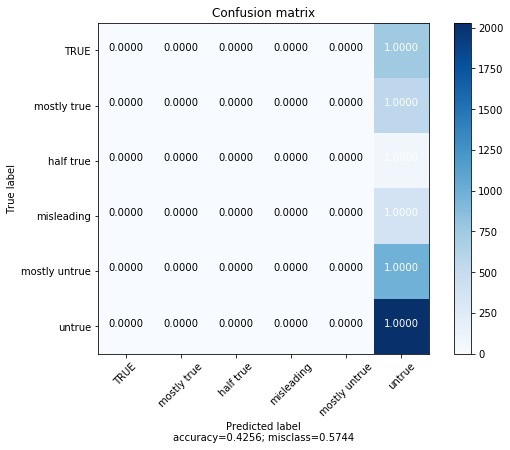

	 stratified dummies classifier
precision: 0.269618701616278
recall: 0.2715043859649123
f1_score: 0.26871527848457377
roc-auc score 0.4972866391483073
confusion matrix: 



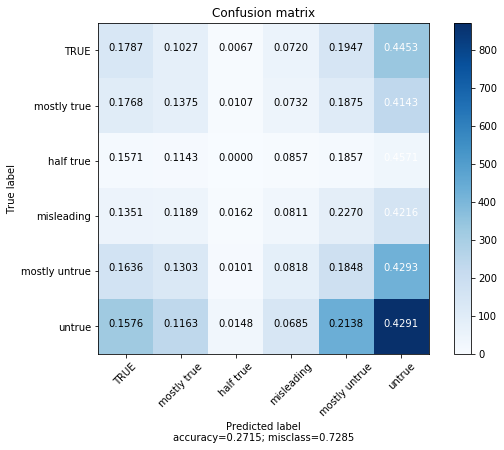

	 model results: 

precision: 0.2841940893695802
recall: 0.32699122807017533
f1_score: 0.29475397574212164
roc-auc score 0.5347372238198848
confusion matrix: 



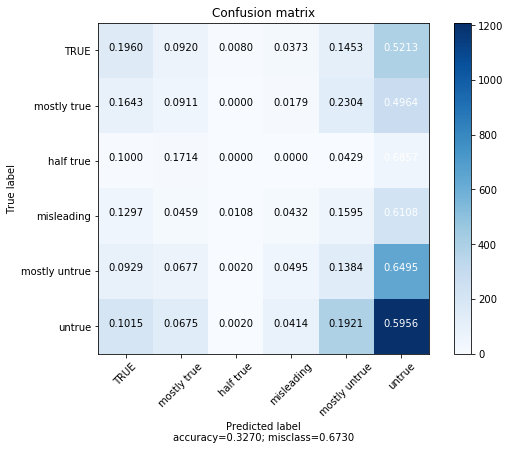

In [62]:
train_kfolds(dataset,return_raw_dataset,smote=False,class_weight=None)

In [32]:
roc_auc_score(y_true,y_score,multi_class='ovr')

0.5232759439392721

In [20]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,return_raw_dataset,smote=False,class_weight=None)

train most frequent classifer...
accuracy 0.4270833333333333
               precision    recall  f1-score   support

         TRUE       0.00      0.00      0.00        16
    half true       0.00      0.00      0.00         8
   misleading       0.00      0.00      0.00         1
  mostly true       0.00      0.00      0.00         6
mostly untrue       0.00      0.00      0.00        24
       untrue       0.43      1.00      0.60        41

     accuracy                           0.43        96
    macro avg       0.07      0.17      0.10        96
 weighted avg       0.18      0.43      0.26        96

train stratified(class weighted) classifier 
accuracy 0.23958333333333334
               precision    recall  f1-score   support

         TRUE       0.14      0.12      0.13        16
    half true       0.00      0.00      0.00         8
   misleading       0.00      0.00      0.00         1
  mostly true       0.00      0.00      0.00         6
mostly untrue       0.25      0.21  

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finish training.
X_test scores : 
 (array(['TRUE', 'half true', 'misleading', 'mostly true', 'mostly untrue',
       'untrue'], dtype=object), array([16,  8,  1,  6, 24, 41], dtype=int64))
Done!


In [21]:
dataset.groupby(['score'])['score'].count()

score
TRUE              75
half true         56
misleading         7
mostly true       37
mostly untrue     99
untrue           203
Name: score, dtype: int64

#### classification_report

In [22]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.3541666666666667
               precision    recall  f1-score   support

         TRUE       0.33      0.25      0.29        16
    half true       0.00      0.00      0.00         8
   misleading       0.00      0.00      0.00         1
  mostly true       0.00      0.00      0.00         6
mostly untrue       0.22      0.17      0.19        24
       untrue       0.45      0.63      0.53        41

     accuracy                           0.35        96
    macro avg       0.17      0.18      0.17        96
 weighted avg       0.30      0.35      0.32        96



C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### confusion matrix

In [23]:
cm=confusion_matrix(y_test, y_pred)

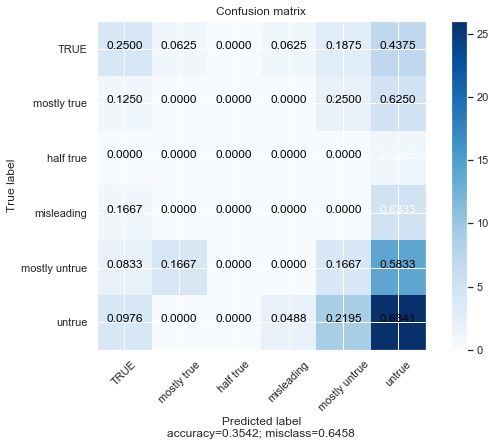

In [353]:
plot_confusion_matrix(cm,target_names=['TRUE','mostly true','half true','misleading','mostly untrue','untrue'])

#### recall 

In [354]:
recall_score(y_test, y_pred,average='weighted')

0.3541666666666667

In [355]:
f1_score(y_test, y_pred,average='weighted')

0.3195646945646946

#### feature importance

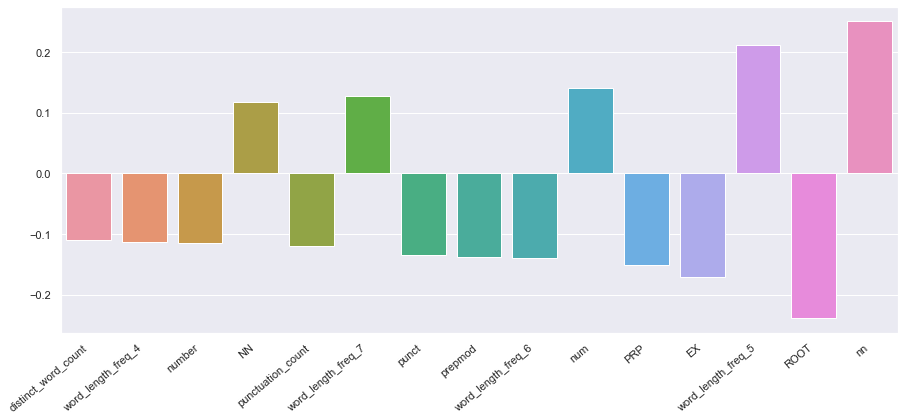

In [356]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### raw dataset with oversampling

In [147]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.024724073753462594
recall: 0.15723684210526317
f1_score: 0.04272921246605455
roc-auc score 0.5
confusion matrix: 



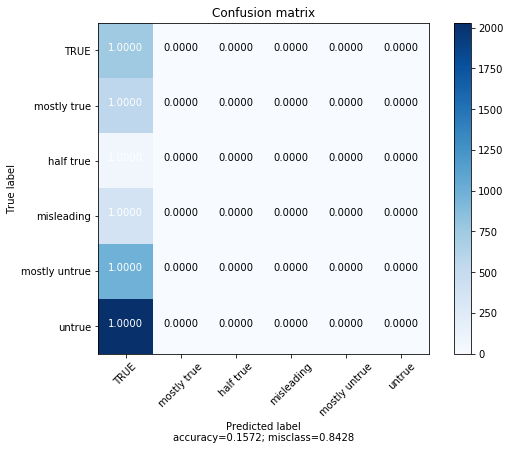

	 stratified dummies classifier
precision: 0.2637229045904225
recall: 0.19035526315789472
f1_score: 0.20205941413006273
roc-auc score 0.4996419103520953
confusion matrix: 



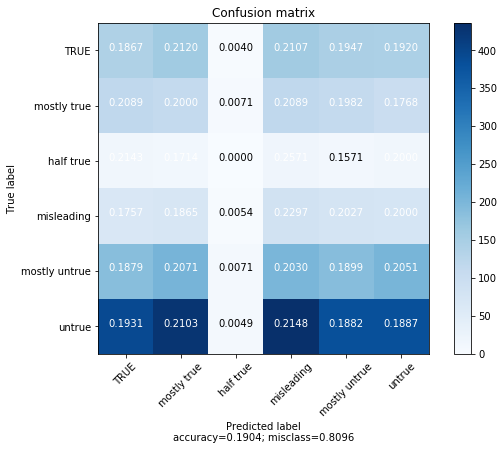

	 model results: 

precision: 0.2926152576271198
recall: 0.23206140350877189
f1_score: 0.24544239497754933
roc-auc score 0.5358696906329743
confusion matrix: 



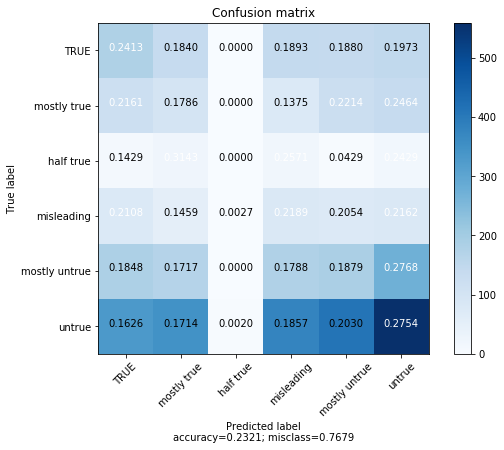

TypeError: cannot unpack non-iterable NoneType object

In [148]:
train_kfolds(dataset,return_raw_dataset,smote=True,class_weight=None)

In [ ]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,return_raw_dataset,smote=True,class_weight=None)

In [362]:
dataset.groupby(['score'])['score'].count()

score
TRUE              75
half true         56
misleading         7
mostly true       37
mostly untrue     99
untrue           203
Name: score, dtype: int64

#### classification report

In [363]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.23958333333333334
               precision    recall  f1-score   support

         TRUE       0.20      0.12      0.15        16
    half true       0.05      0.12      0.07         8
   misleading       0.00      0.00      0.00         1
  mostly true       0.15      0.50      0.23         6
mostly untrue       0.23      0.21      0.22        24
       untrue       0.57      0.29      0.39        41

     accuracy                           0.24        96
    macro avg       0.20      0.21      0.18        96
 weighted avg       0.35      0.24      0.27        96



#### confusion matrix

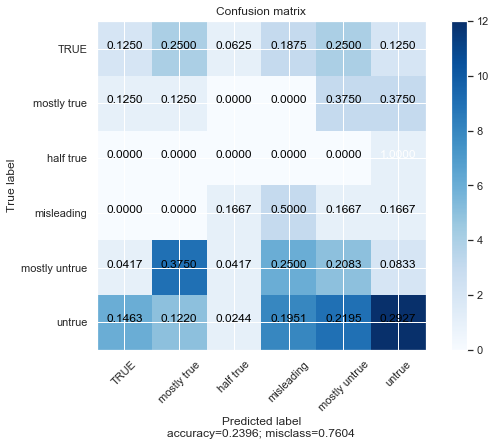

In [364]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','mostly true','half true','misleading','mostly untrue','untrue'])

#### recall

In [365]:
recall_score(y_test, y_pred,average='weighted')

0.23958333333333334

In [366]:
f1_score(y_test, y_pred,average='weighted')

0.26590734880239325

#### feature importance

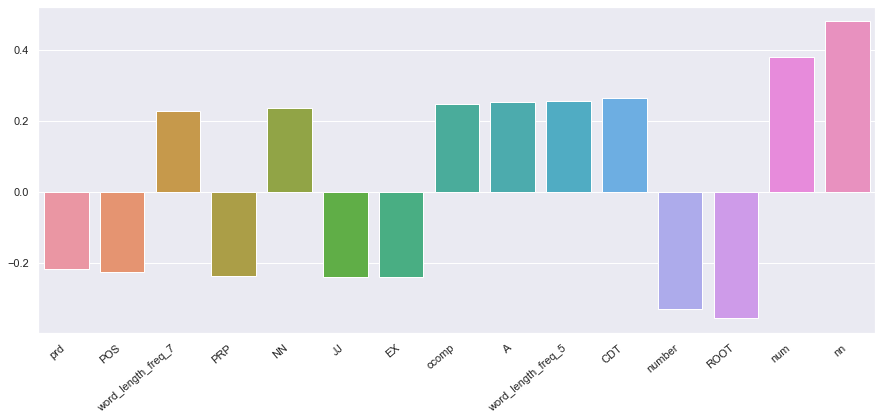

In [232]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### True and Untrue only dataset without oversampling

In [70]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.5331901458930678
recall: 0.730194805194805
f1_score: 0.6163310102810917
roc-auc score 0.5
confusion matrix: 



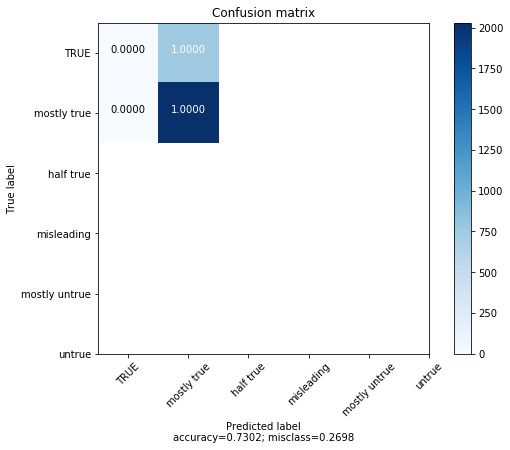

	 stratified dummies classifier
precision: 0.5985391176825332
recall: 0.5963506493506492
f1_score: 0.5954023790805215
roc-auc score 0.5095203252032522
confusion matrix: 



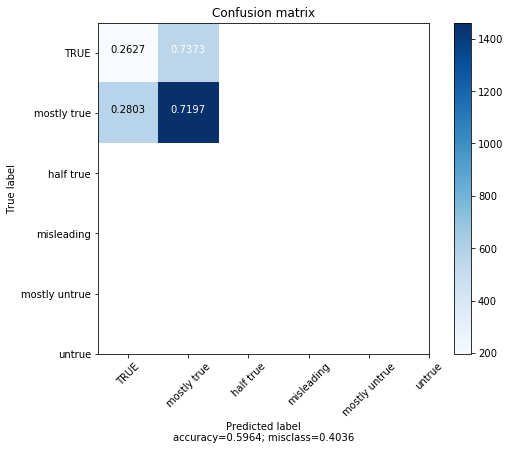

	 model results: 

precision: 0.6405307842998762
recall: 0.606461038961039
f1_score: 0.6182700007610145
roc-auc score 0.5594105691056909
confusion matrix: 



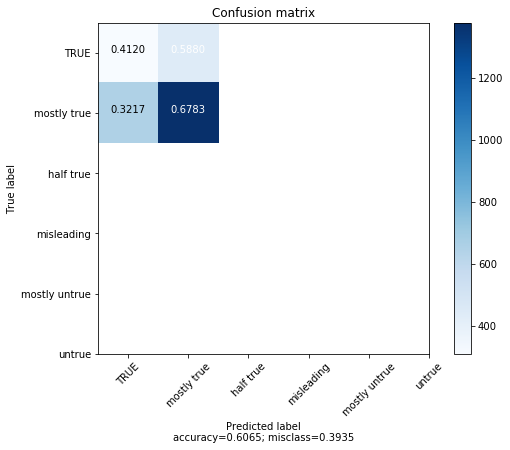

In [149]:
train_kfolds(dataset,trueNuntrueStmt,smote=False,class_weight='balanced')

In [368]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,trueNuntrueStmt,smote=False,class_weight='balanced')

train most frequent classifer...
accuracy 0.7321428571428571
              precision    recall  f1-score   support

        TRUE       0.00      0.00      0.00        15
      untrue       0.73      1.00      0.85        41

    accuracy                           0.73        56
   macro avg       0.37      0.50      0.42        56
weighted avg       0.54      0.73      0.62        56

train stratified(class weighted) classifier 
accuracy 0.6071428571428571
              precision    recall  f1-score   support

        TRUE       0.23      0.20      0.21        15
      untrue       0.72      0.76      0.74        41

    accuracy                           0.61        56
   macro avg       0.48      0.48      0.48        56
weighted avg       0.59      0.61      0.60        56



C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finish training.
X_test scores : 
 (array(['TRUE', 'untrue'], dtype=object), array([15, 41], dtype=int64))
Done!


In [369]:
dataset.groupby(['score'])['score'].count()

score
TRUE       75
untrue    203
Name: score, dtype: int64

#### classification report

In [370]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.625
              precision    recall  f1-score   support

        TRUE       0.33      0.40      0.36        15
      untrue       0.76      0.71      0.73        41

    accuracy                           0.62        56
   macro avg       0.55      0.55      0.55        56
weighted avg       0.65      0.62      0.63        56



#### confusion matrix

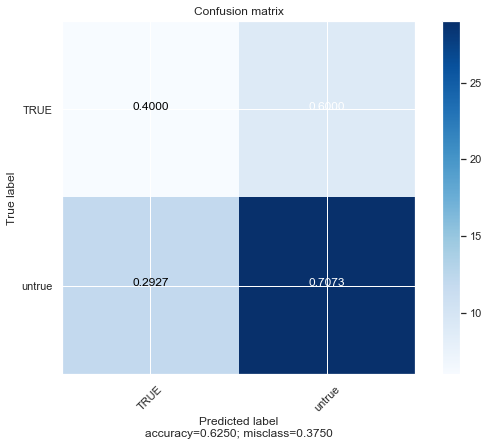

In [372]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','untrue'])

#### recall

In [375]:
recall_score(y_test, y_pred,average='weighted')

0.625

In [376]:
f1_score(y_test, y_pred,average='weighted')

0.6349252013808976

#### Feature importance

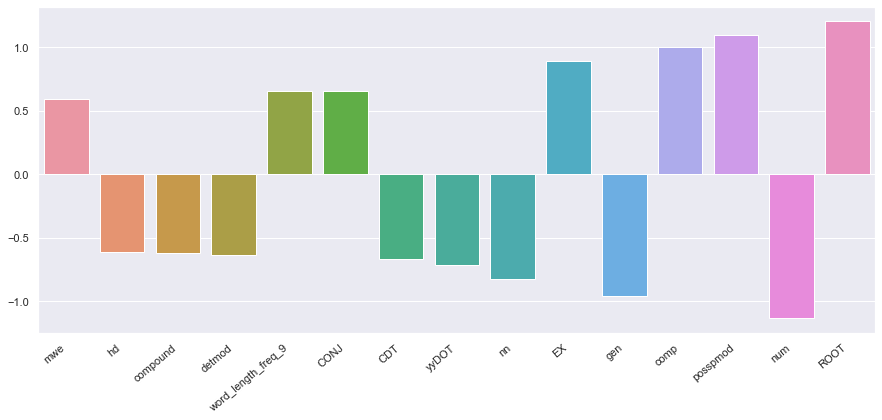

In [377]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### True and Untrue only dataset with oversampling

In [150]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.5331901458930678
recall: 0.730194805194805
f1_score: 0.6163310102810917
roc-auc score 0.5
confusion matrix: 



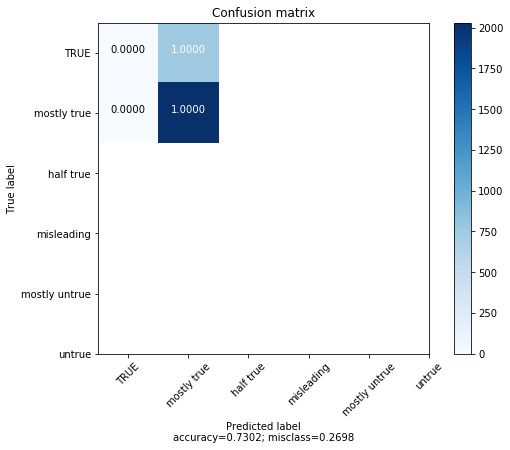

	 stratified dummies classifier
precision: 0.6093216744701929
recall: 0.6125194805194806
f1_score: 0.6089800115339652
roc-auc score 0.49301829268292674
confusion matrix: 



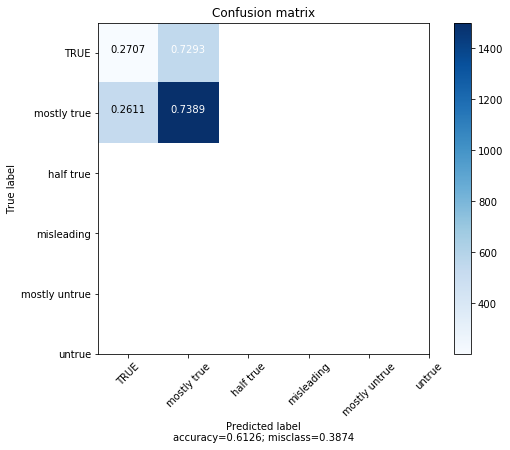

	 model results: 

precision: 0.6294047796339318
recall: 0.5993376623376624
f1_score: 0.6089249640264223
roc-auc score 0.5673780487804877
confusion matrix: 



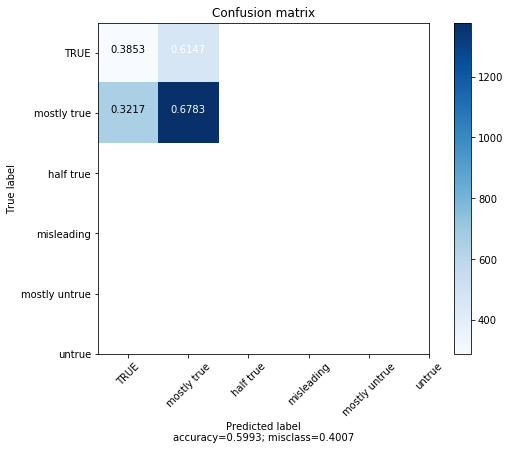

In [151]:
train_kfolds(dataset,trueNuntrueStmt,smote=True,class_weight='balanced')

In [379]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,trueNuntrueStmt,smote=True,class_weight=None)

train most frequent classifer...
accuracy 0.7321428571428571
              precision    recall  f1-score   support

        TRUE       0.00      0.00      0.00        15
      untrue       0.73      1.00      0.85        41

    accuracy                           0.73        56
   macro avg       0.37      0.50      0.42        56
weighted avg       0.54      0.73      0.62        56

train stratified(class weighted) classifier 
accuracy 0.5892857142857143
              precision    recall  f1-score   support

        TRUE       0.25      0.27      0.26        15
      untrue       0.72      0.71      0.72        41

    accuracy                           0.59        56
   macro avg       0.49      0.49      0.49        56
weighted avg       0.60      0.59      0.59        56

Applying SMOTE to oversampling...


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


new counts are : 
 (array(['TRUE', 'untrue'], dtype=object), array([162, 162], dtype=int64))
Finish training.
X_test scores : 
 (array(['TRUE', 'untrue'], dtype=object), array([15, 41], dtype=int64))
Done!


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [380]:
dataset.groupby(['score'])['score'].count()

score
TRUE       75
untrue    203
Name: score, dtype: int64

#### classification report

In [381]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6785714285714286
              precision    recall  f1-score   support

        TRUE       0.40      0.40      0.40        15
      untrue       0.78      0.78      0.78        41

    accuracy                           0.68        56
   macro avg       0.59      0.59      0.59        56
weighted avg       0.68      0.68      0.68        56



#### confusion matrix

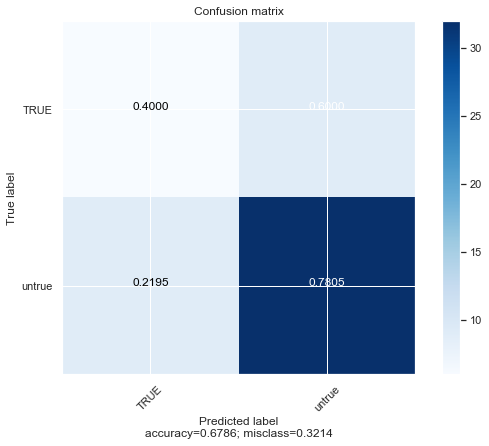

In [382]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','untrue'])

#### recall

In [383]:
recall_score(y_test, y_pred,average='weighted')

0.6785714285714286

In [384]:
f1_score(y_test, y_pred,average='weighted')

0.6785714285714286

In [385]:
#### Feature importance

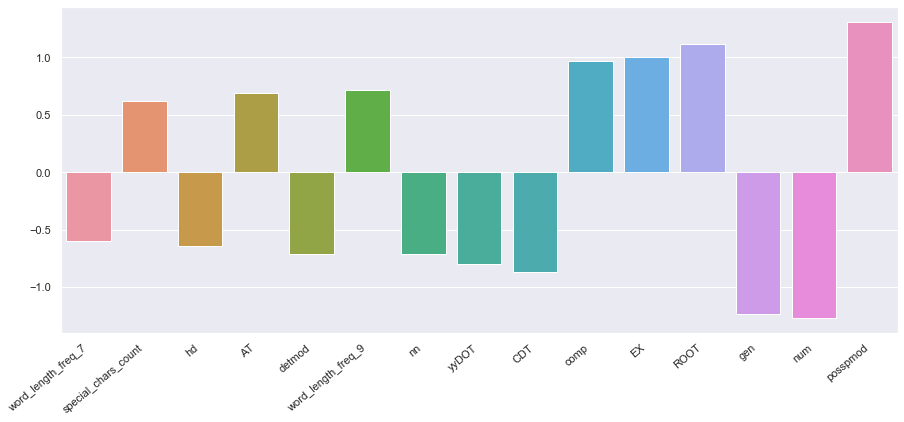

In [386]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### True vs All without oversampling


In [152]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.7102503895429364
recall: 0.842763157894737
f1_score: 0.7708531923027913
roc-auc score 0.5
confusion matrix: 



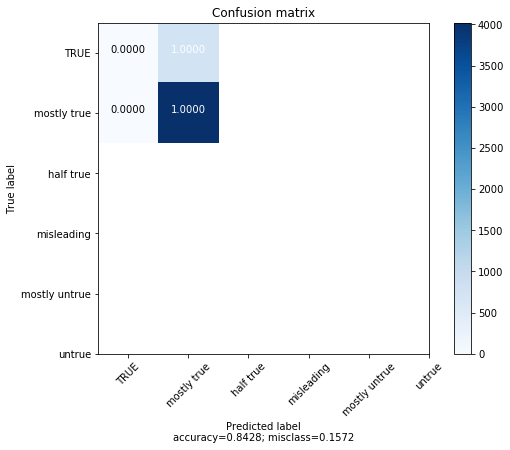

	 stratified dummies classifier
precision: 0.7319945510829694
recall: 0.7360614035087721
f1_score: 0.7331185531426564
roc-auc score 0.4897021604938271
confusion matrix: 



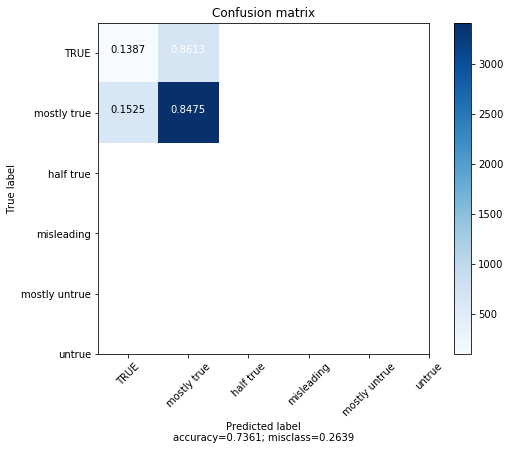

	 model results: 

precision: 0.774782190830815
recall: 0.8071096491228067
f1_score: 0.785628882624043
roc-auc score 0.5863238683127572
confusion matrix: 



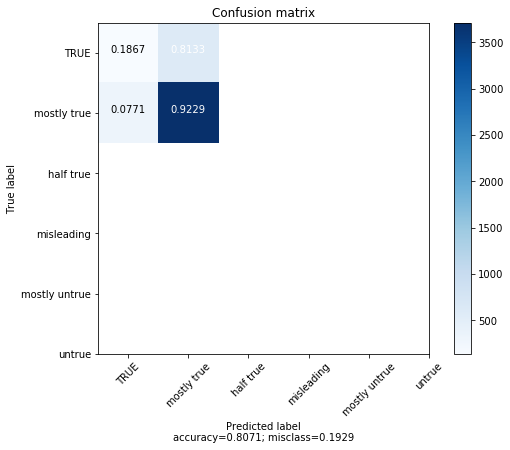

In [153]:
train_kfolds(dataset,trueVSall,smote=False,class_weight=None)

In [388]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,trueVSall,smote=False,class_weight='balanced')

train most frequent classifer...
accuracy 0.8333333333333334
              precision    recall  f1-score   support

        TRUE       0.00      0.00      0.00        16
      untrue       0.83      1.00      0.91        80

    accuracy                           0.83        96
   macro avg       0.42      0.50      0.45        96
weighted avg       0.69      0.83      0.76        96

train stratified(class weighted) classifier 
accuracy 0.71875
              precision    recall  f1-score   support

        TRUE       0.18      0.19      0.18        16
      untrue       0.84      0.82      0.83        80

    accuracy                           0.72        96
   macro avg       0.51      0.51      0.51        96
weighted avg       0.73      0.72      0.72        96



C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finish training.
X_test scores : 
 (array(['TRUE', 'untrue'], dtype=object), array([16, 80], dtype=int64))
Done!


In [389]:
dataset.groupby(['score'])['score'].count()

score
TRUE       75
untrue    402
Name: score, dtype: int64

#### classification report

In [390]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6979166666666666
              precision    recall  f1-score   support

        TRUE       0.24      0.38      0.29        16
      untrue       0.86      0.76      0.81        80

    accuracy                           0.70        96
   macro avg       0.55      0.57      0.55        96
weighted avg       0.76      0.70      0.72        96



#### confusion matrix

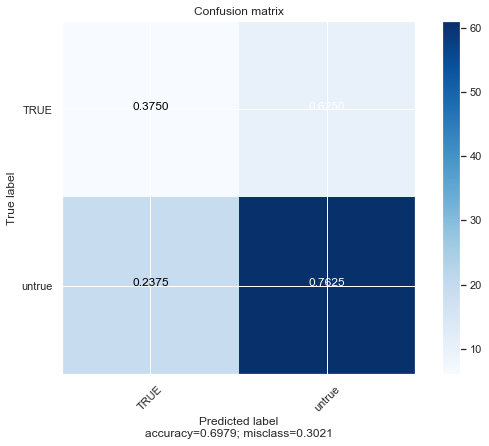

In [391]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','untrue'])

#### recall

In [392]:
recall_score(y_test, y_pred,average='weighted')

0.6979166666666666

In [393]:
f1_score(y_test, y_pred,average='weighted')

0.7220696710278361

##### Feature importance

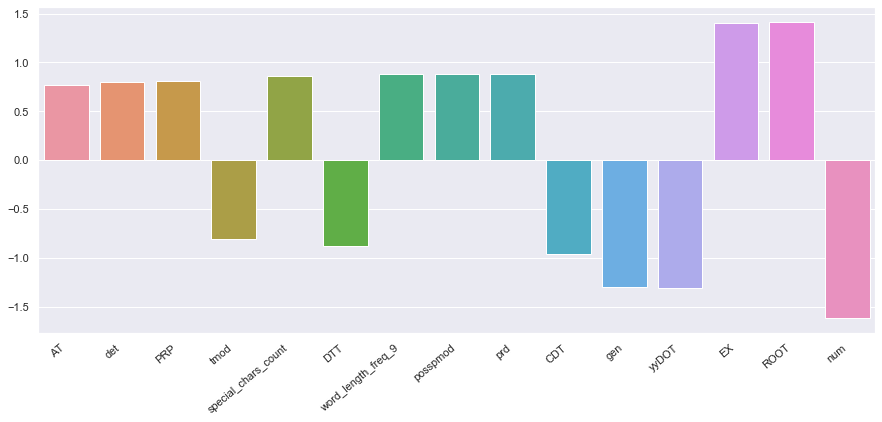

In [394]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### True vs All with oversampling


In [154]:
dataset=raw_dataset.copy()

Results Summary:

	 dummies classifiers results:

	 most frequent dummies classifier
precision: 0.7102503895429364
recall: 0.842763157894737
f1_score: 0.7708531923027913
roc-auc score 0.5
confusion matrix: 



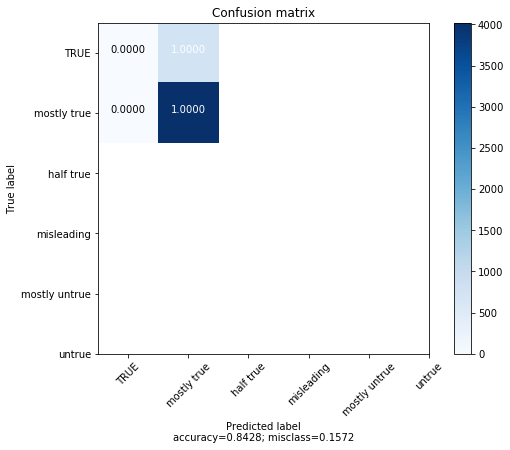

	 stratified dummies classifier
precision: 0.7346748586790776
recall: 0.7369254385964912
f1_score: 0.7350790415851323
roc-auc score 0.5012685185185185
confusion matrix: 



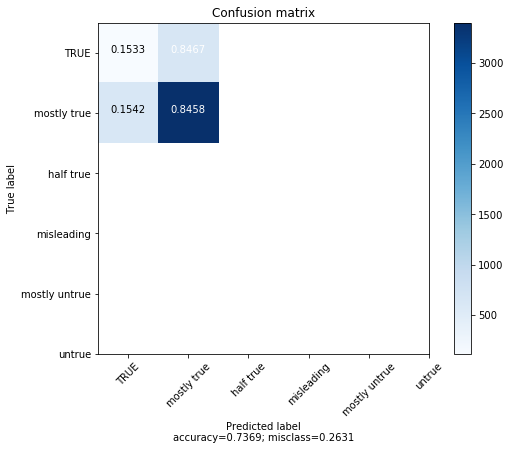

	 model results: 

precision: 0.7754382296475878
recall: 0.8146842105263158
f1_score: 0.7889231248864292
roc-auc score 0.5873462962962963
confusion matrix: 



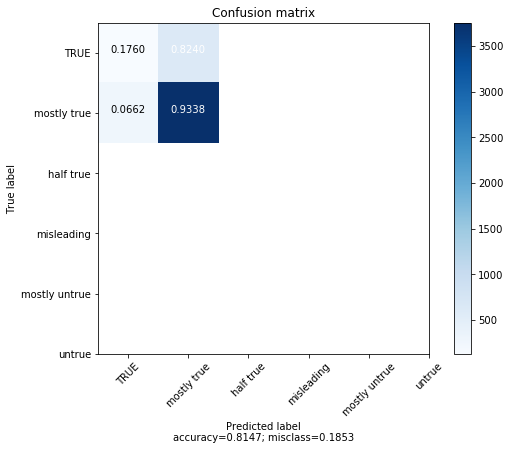

In [155]:
train_kfolds(dataset,trueVSall,smote=True,class_weight=None)

In [399]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,trueVSall,smote=True,class_weight=None)

train most frequent classifer...
accuracy 0.8333333333333334
              precision    recall  f1-score   support

        TRUE       0.00      0.00      0.00        16
      untrue       0.83      1.00      0.91        80

    accuracy                           0.83        96
   macro avg       0.42      0.50      0.45        96
weighted avg       0.69      0.83      0.76        96

train stratified(class weighted) classifier 
accuracy 0.78125
              precision    recall  f1-score   support

        TRUE       0.27      0.19      0.22        16
      untrue       0.85      0.90      0.87        80

    accuracy                           0.78        96
   macro avg       0.56      0.54      0.55        96
weighted avg       0.75      0.78      0.76        96

Applying SMOTE to oversampling...


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


new counts are : 
 (array(['TRUE', 'untrue'], dtype=object), array([322, 322], dtype=int64))


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finish training.
X_test scores : 
 (array(['TRUE', 'untrue'], dtype=object), array([16, 80], dtype=int64))
Done!


In [400]:
dataset.groupby(['score'])['score'].count()

score
TRUE       75
untrue    402
Name: score, dtype: int64

#### classification report

In [401]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6979166666666666
              precision    recall  f1-score   support

        TRUE       0.22      0.31      0.26        16
      untrue       0.85      0.78      0.81        80

    accuracy                           0.70        96
   macro avg       0.53      0.54      0.53        96
weighted avg       0.74      0.70      0.72        96



#### confusion matrix

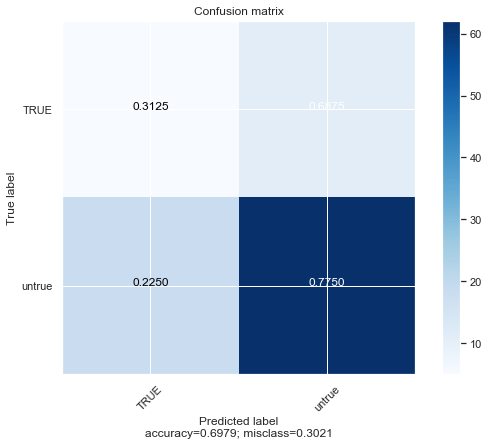

In [403]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','untrue'])

#### recall

In [404]:
recall_score(y_test, y_pred,average='weighted')

0.6979166666666666

In [405]:
f1_score(y_test, y_pred,average='weighted')

0.7181163063516004

##### Feature importance

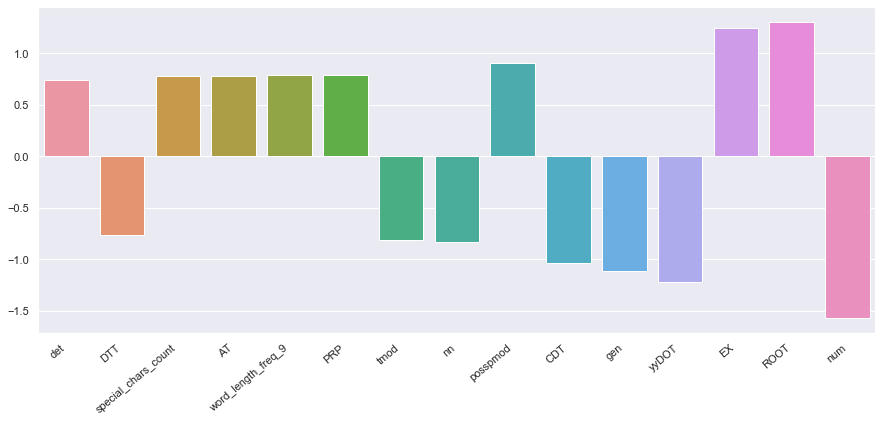

In [406]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### Written stmt only without oversampling

In [219]:
collections.Counter(written_only(dataset).score)

Counter({'untrue': 26,
         'half true': 9,
         'mostly true': 2,
         'mostly untrue': 9,
         'TRUE': 26})

In [222]:
dataset=raw_dataset.copy()

dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
Results Summary:

	 dummies classifiers results:

	 most frequent dummies classi

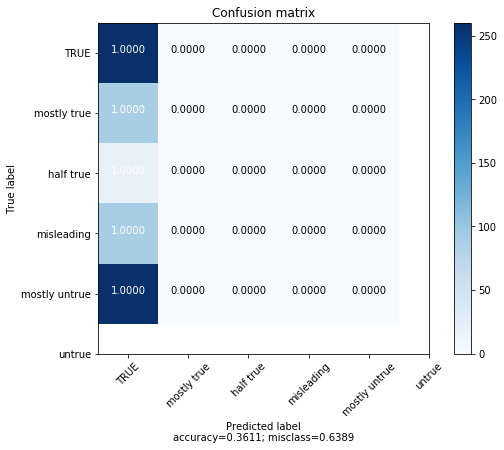

	 stratified dummies classifier
precision: 0.2858613047491724
recall: 0.28055555555555556
f1_score: 0.2790972160460058
roc-auc score 0.49940147554058845
confusion matrix: 



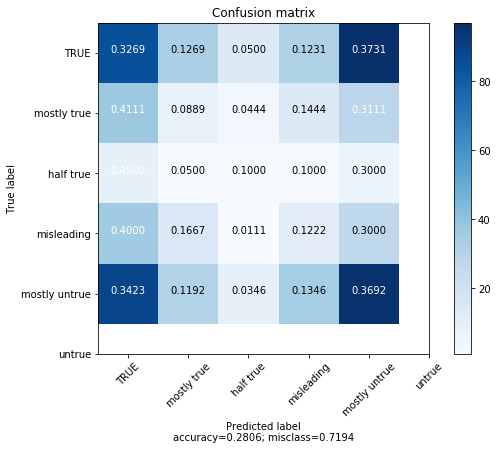

	 model results: 

precision: 0.3704805013677339
recall: 0.37638888888888894
f1_score: 0.3642284818405739
roc-auc score 0.5853038777491794
confusion matrix: 



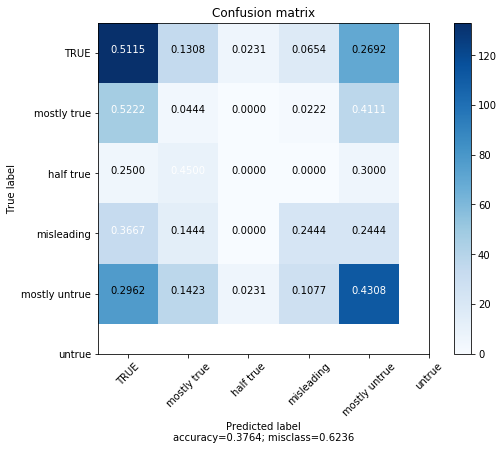

In [223]:
train_kfolds(dataset,written_only,smote=False,class_weight='balanced')

In [408]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(dataset,written_only,smote=False,class_weight='balanced')

train most frequent classifer...
accuracy 0.3333333333333333
              precision    recall  f1-score   support

        TRUE       0.33      1.00      0.50         5
 mostly true       0.00      0.00      0.00         2
      untrue       0.00      0.00      0.00         8

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15

train stratified(class weighted) classifier 
accuracy 0.4666666666666667
               precision    recall  f1-score   support

         TRUE       0.67      0.40      0.50         5
    half true       0.00      0.00      0.00         0
  mostly true       0.00      0.00      0.00         2
mostly untrue       0.00      0.00      0.00         0
       untrue       0.71      0.62      0.67         8

     accuracy                           0.47        15
    macro avg       0.28      0.20      0.23        15
 weighted avg       0.60      0.47      0.5

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finish training.
X_test scores : 
 (array(['TRUE', 'mostly true', 'untrue'], dtype=object), array([5, 2, 8], dtype=int64))
Done!


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [409]:
dataset.groupby(['score'])['score'].count()

score
TRUE             26
half true         9
mostly true       2
mostly untrue     9
untrue           26
Name: score, dtype: int64

#### classification report

In [410]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.4
               precision    recall  f1-score   support

         TRUE       0.75      0.60      0.67         5
    half true       0.00      0.00      0.00         0
  mostly true       0.00      0.00      0.00         2
mostly untrue       0.00      0.00      0.00         0
       untrue       0.60      0.38      0.46         8

     accuracy                           0.40        15
    macro avg       0.27      0.20      0.23        15
 weighted avg       0.57      0.40      0.47        15



C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### confusion matrix

C:\Users\Ben\FakeNews_Notebook\organized\model_statistics_func.py:78: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


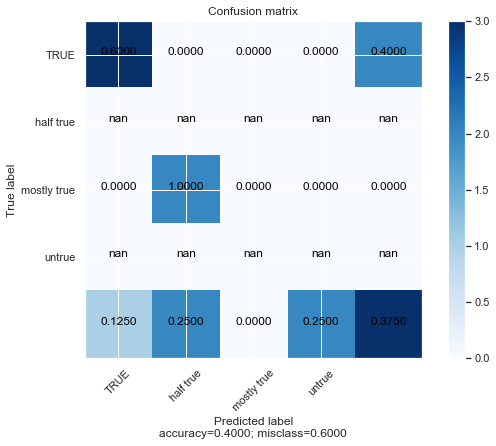

In [411]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','half true','mostly true','untrue'])

#### recall

In [412]:
recall_score(y_test, y_pred,average='weighted')

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4

#### feature importance

In [413]:
f1_score(y_test, y_pred,average='weighted')

0.4683760683760683

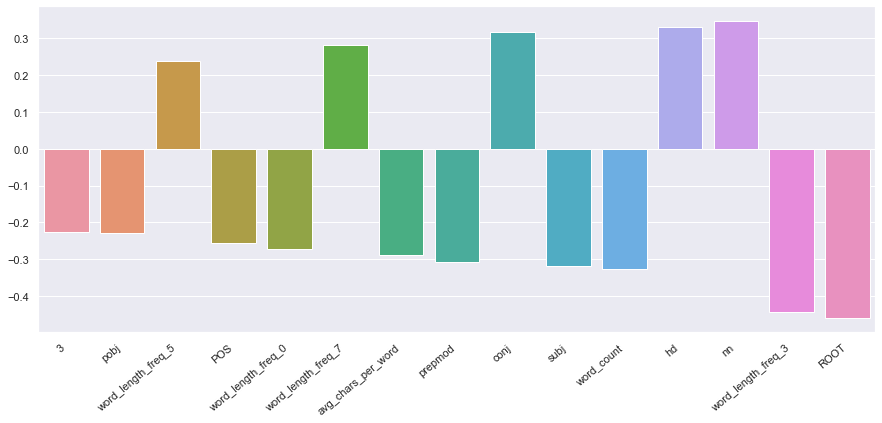

In [414]:
feature_importance_dict=get_feature_importance(dataset,logreg)

## Train Model  - LogisticRegression
#### Written stmt only with oversampling

In [224]:
dataset=raw_dataset.copy()

dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
dummies results
dummies results
model results
Results Summary:

	 dummies classifiers results:

	 most frequent dummies classi

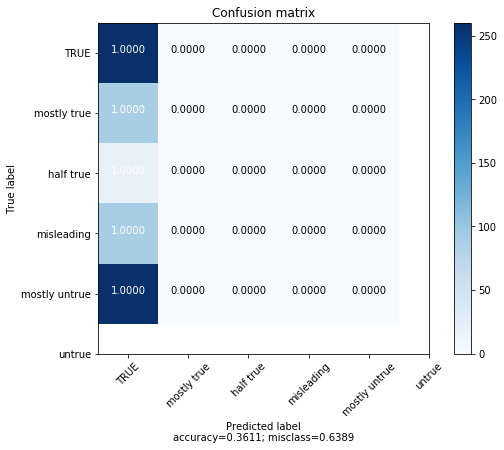

	 stratified dummies classifier
precision: 0.3366105998213841
recall: 0.25972222222222224
f1_score: 0.2695672539985087
roc-auc score 0.5056820372824931
confusion matrix: 



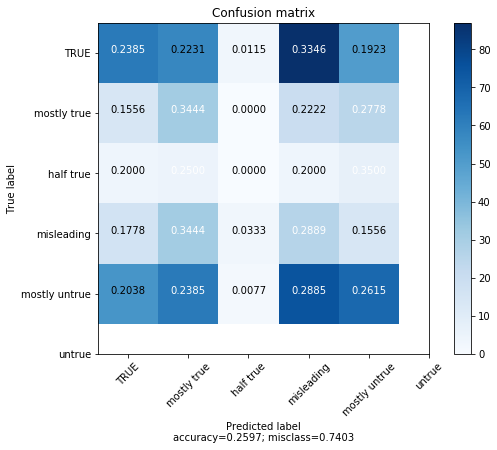

	 model results: 

precision: 0.37607980272341085
recall: 0.3791666666666666
f1_score: 0.36512062766721676
roc-auc score 0.5727936952379667
confusion matrix: 



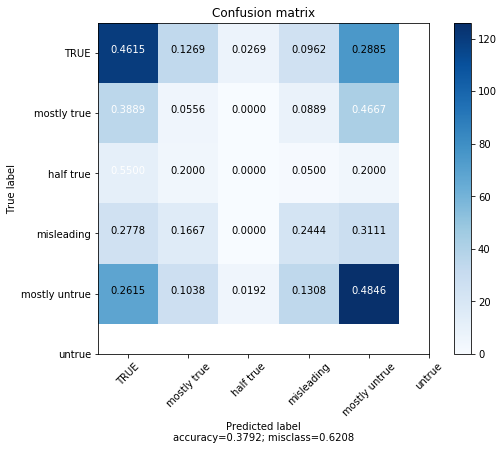

In [225]:
train_kfolds(dataset,written_only,smote=True,class_weight='balanced')

In [416]:
logreg,y_test,y_pred,dataset=global_train_Lg_model(raw_dataset,written_only,smote=True,class_weight='balanced')

train most frequent classifer...
accuracy 0.3333333333333333
              precision    recall  f1-score   support

        TRUE       0.33      1.00      0.50         5
 mostly true       0.00      0.00      0.00         2
      untrue       0.00      0.00      0.00         8

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15

train stratified(class weighted) classifier 
accuracy 0.06666666666666667
               precision    recall  f1-score   support

         TRUE       0.14      0.20      0.17         5
    half true       0.00      0.00      0.00         0
  mostly true       0.00      0.00      0.00         2
mostly untrue       0.00      0.00      0.00         0
       untrue       0.00      0.00      0.00         8

     accuracy                           0.07        15
    macro avg       0.03      0.04      0.03        15
 weighted avg       0.05      0.07      0.

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finish training.
X_test scores : 
 (array(['TRUE', 'mostly true', 'untrue'], dtype=object), array([5, 2, 8], dtype=int64))
Done!


C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [417]:
dataset.groupby(['score'])['score'].count()

score
TRUE             26
half true         9
mostly true       2
mostly untrue     9
untrue           26
Name: score, dtype: int64

#### classification report

In [418]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.3333333333333333
               precision    recall  f1-score   support

         TRUE       0.60      0.60      0.60         5
    half true       0.00      0.00      0.00         0
  mostly true       0.00      0.00      0.00         2
mostly untrue       0.00      0.00      0.00         0
       untrue       0.50      0.25      0.33         8

     accuracy                           0.33        15
    macro avg       0.22      0.17      0.19        15
 weighted avg       0.47      0.33      0.38        15



C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### confusion matrix

C:\Users\Ben\FakeNews_Notebook\organized\model_statistics_func.py:78: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


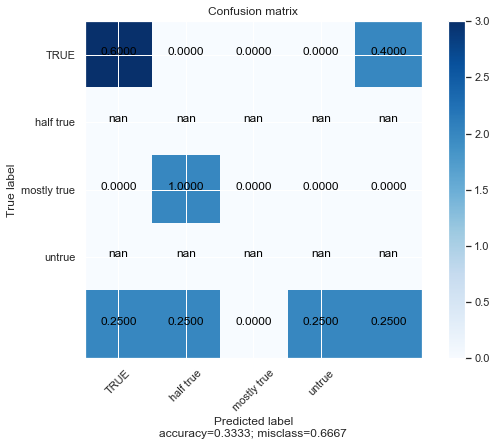

In [419]:
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['TRUE','half true','mostly true','untrue'])

#### recall

In [420]:
recall_score(y_test, y_pred,average='weighted')

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333

In [421]:
f1_score(y_test, y_pred,average='weighted')

0.3777777777777777

#### feature importance

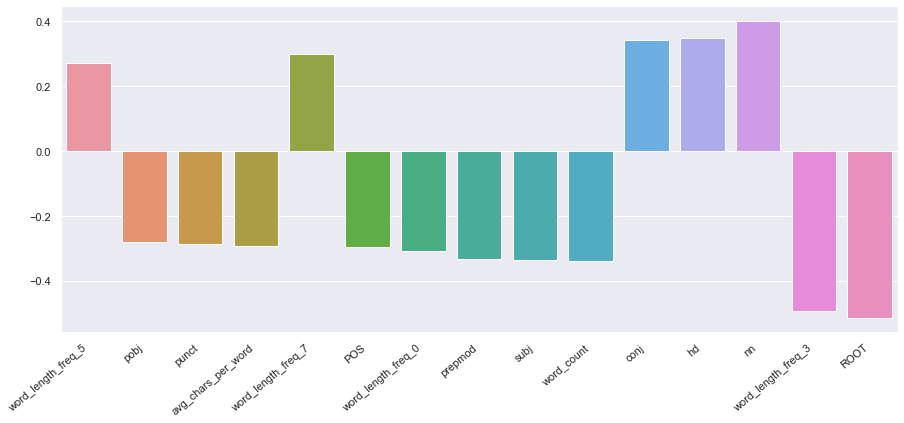

In [422]:
feature_importance_dict=get_feature_importance(dataset,logreg)